In [1]:
%matplotlib inline
from torchvision.models import vgg19, vgg16_bn
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import numbers
import math
import torch.nn.functional as F

In [2]:
def show_tensor(t):
    t = t.detach().squeeze(0) * torch.tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(1) \
     + torch.tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(1)    
    plt.imshow(t.permute(1,2,0).numpy())
    plt.axis('off');
    
class VggExtractor(nn.Module):
    def __init__(self, pool_size=1):
        super().__init__()
        self.extractor = nn.Sequential(
            vgg16_bn(pretrained=True).features,
            nn.AdaptiveAvgPool2d(output_size=(pool_size, pool_size)),
        )
    
    def forward(self, x):
        return self.extractor(x).view(x.size(0), -1)

vgg_extractor = VggExtractor()
for param in vgg_extractor.parameters():
    param.requires_grad = False

In [3]:
normalize = Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = Compose((ToTensor(),normalize))
cifar = CIFAR10('data', transform=transform, download=True)
test = CIFAR10("data", train=False, transform=transform)
loader = DataLoader(cifar, batch_size=32)

Files already downloaded and verified


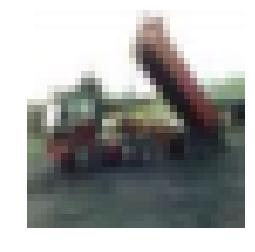

In [4]:
show_tensor(cifar[2][0])

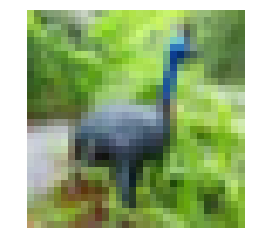

In [5]:
show_tensor(cifar[6][0])

In [29]:
activations = vgg_extractor(cifar[2161][0].unsqueeze(0))
activations.size()

torch.Size([1, 512])

In [10]:
from tqdm import tqdm
features = []
for batch, _ in tqdm(loader):
    with torch.no_grad():
        features.append(vgg_extractor(batch))
features = torch.cat(features)


100%|██████████| 1563/1563 [17:04<00:00,  1.43it/s]


In [74]:
#torch.save(features, 'embeddings.pt')
features = torch.load('embeddings.pt')

In [76]:
emb = vgg_extractor(test[2][0].unsqueeze(0))
distances = torch.norm(features - emb, dim=1)
#Five nearest neighbours
torch.argsort(distances)[:5]

tensor([21562,  2161,  4914, 23106,  4490])

# Optimization-based

In [112]:
from PIL import Image

In [113]:
good_im = Image.open("data/shiba_good.jpg")
bad_im = Image.open("data/shiba_bad.jpg")

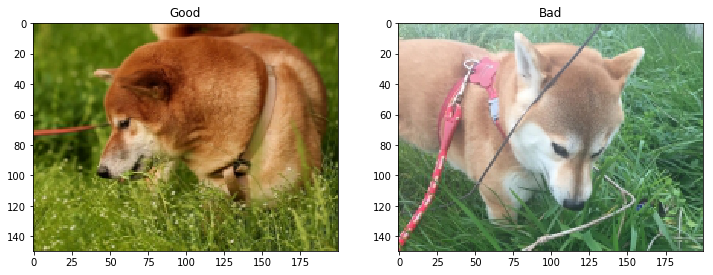

In [114]:
plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
plt.imshow(good_im)
plt.title("Good")
plt.subplot(1, 2, 2)
plt.title("Bad")
plt.imshow(bad_im)

In [6]:
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    Credits: pytorch forum
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, x):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        x = F.pad(x, (2, 2, 2, 2), mode='reflect')
        return self.conv(x, weight=self.weight, groups=self.groups)

In [116]:
from torch.optim import LBFGS
smoothing = GaussianSmoothing(3, 10, 5)
mse = nn.MSELoss()

g = good_tens.unsqueeze(0)
b = bad_tens.unsqueeze(0)
b_content = vgg_extractor(b)

def closure():
    alpha = 0.2
    # correct the values of updated input image
    b.data.clamp_(0, 1)
    optimizer.zero_grad()
    smooth_b_feat, smooth_g_feat = vgg_extractor(smoothing(b)), vgg_extractor(smoothing(g))
    color_loss = mse(smooth_b_feat, smooth_g_feat)
    #content_loss = mse(b_content, vgg_extractor(b.detach()))
    #loss = color_loss + alpha * content_loss
    color_loss.backward()
    return loss

optimizer = LBFGS([b.requires_grad_()])
optimizer.step(closure)
show_tensor(b)

AttributeError: module 'torch' has no attribute 'meshgrid'

# Losses

In [7]:
class VGG(nn.Module):

    def __init__(self):
        super(VGG, self).__init__()
        self.model = vgg16_bn(True).features
        self.mean = torch.Tensor([123.68,  116.779,  103.939]).view(1,3,1,1)
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = x*255 - self.mean
        x = self.model(x)
        return x

In [17]:
def content_loss(original_img,target_img):
    _, c1, h1, w1 = original_img.size()
    chw1 = c1 * h1 * w1
    vgg_original = vgg(original_img)
    vgg_enhanched = vgg(target_img)
    content_loss = 1.0/chw1 * nn.MSELoss()(vgg_original, vgg_enhanched)
    return content_loss

def color_loss(original_img,target_img):
    batch_size = original_img.size()[0]
    smoothing = GaussianSmoothing(3, 10, 5)
    original_blur = smoothing(original_img)
    target_blur = smoothing(target_img)
    return torch.sum(torch.pow(target_blur-original_blur,2))/(2 * batch_size)


In [14]:
x1 = cifar[4][0].unsqueeze(0)
x2 = cifar[6][0].unsqueeze(0)
x3 = cifar[1][0].unsqueeze(0)
vgg = VGG()

In [15]:
content_loss(x1,x2), content_loss(x1,x3), content_loss(x2,x3)

(tensor(1.9570e-05), tensor(2.0095e-05), tensor(2.1199e-05))

In [20]:
color_loss(x1,x2), color_loss(x1,x3), color_loss(x2,x3)

(tensor(956.3493), tensor(790.0882), tensor(707.8542))

In [12]:
#    loss_color = tf.reduce_sum(tf.pow(dslr_blur - enhanced_blur, 2))/(2 * batch_size)
smoothing = GaussianSmoothing(3, 10, 5)
x1_blur = smoothing(x1)
x2_blur = smoothing(x2)
torch.sum(torch.pow(x1_blur-x2_blur,2))/2

tensor(956.3493)